https://finance.yahoo.com/commodities/

https://gsnchez.com/blog/article/Optimizacion-algoritmica-de-carteras-con-markowitz

Importamos las librerias necesarias.

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as wb
from time import time
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel, RationalQuadratic, RBF
from sklearn.gaussian_process import GaussianProcessRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
symbols = pd.read_csv('futures.txt', sep=';', header = 0)

Descargamos el dataset a estudiar.

In [3]:
stock = symbols[symbols['Name'] == 'Natural Gas']['symbol'].values[0]
natural_gas = wb.DataReader(stock, data_source='yahoo', start='1900-1-1')

In [4]:
natural_gas.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-08-30,4.815,4.63,4.65,4.805,34954.0,4.805
2000-08-31,4.870,4.74,4.82,4.780,25787.0,4.780
2000-09-01,4.860,4.75,4.75,4.835,113.0,4.835
2000-09-05,4.975,4.84,4.85,4.960,26096.0,4.960
2000-09-06,5.110,4.96,4.99,5.065,32764.0,5.065


Transformamos el dataset a series de precios (Adj Close) anuales.

In [5]:
starts, ends = [], []
for i in range(1,22):
    starts.append('20{:02d}-01-01'.format(i))
    ends.append('20{:02d}-12-31'.format(i))

In [6]:
sd = np.std(natural_gas['Adj Close'].values)
natural_gas_years = pd.DataFrame()
for start, end in zip(starts, ends):
    s = [None] * 253
    v = natural_gas['Adj Close'][start:end].values
    v = (v - v[0]) / sd
    s[:len(v)] = v
    natural_gas_years[end[:4]] = s

In [7]:
natural_gas_years.head()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.064364,-0.088054,0.041569,0.113978,0.050061,-0.191752,-0.060788,-0.078668,0.045144,-0.110403,...,0.046038,-0.015644,-0.007599,-0.054084,-0.004023,-0.026818,-0.021455,-0.005811,0.003576,0.054084
2,0.284276,-0.084925,-0.141244,0.022796,0.019220,-0.503740,-0.061235,-0.004023,0.005364,0.055872,...,-0.005811,0.024137,-0.006705,-0.029053,-0.029947,-0.024137,-0.078667,0.038440,0.005811,0.060342
3,0.396019,-0.086266,-0.055425,0.119342,0.115766,-0.444293,-0.051402,0.012962,-0.044250,-0.034864,...,0.030841,0.014750,-0.009834,-0.059001,0.021455,-0.018773,-0.116660,-0.006258,0.017879,0.066152
4,0.597157,-0.082243,-0.040228,0.205608,0.094312,-0.552460,0.035311,0.052296,-0.173426,-0.060341,...,0.008045,-0.006705,-0.046932,-0.033970,0.061682,-0.100122,-0.098781,0.004023,0.008493,0.053190


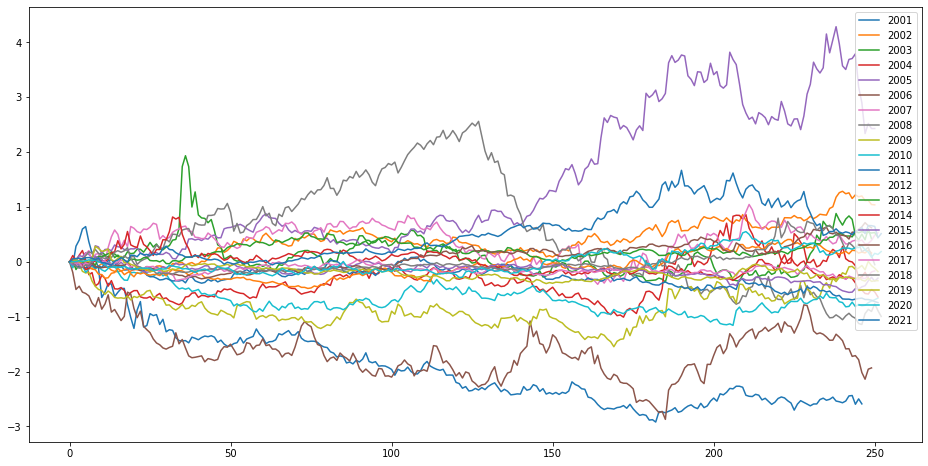

In [8]:
natural_gas_plot = natural_gas_years.plot(figsize=(16,8), legend=True, linewidth=1.5)

Obtenemos las matrices X e y. La matriz X tiene como columnas la variable año actual y la variable dia actual. La matriz y tiene los precios correspondientes a cada fila de X.

In [9]:
days = natural_gas_years.index.values
years = [int(year) for year in natural_gas_years.columns.values]

X = pd.DataFrame(columns=['year', 'day'])
y, i = np.array([None] * len(years) * len(days)), 0
for year in years:
    for day in days:
        X.loc[i, 'year'], X.loc[i, 'day'] = year, day
        y[i] = natural_gas_years[str(year)].values[day]
        i += 1

X = X.loc[~np.isnan(list(y)),:].reset_index(drop=True)
y = y[~np.isnan(list(y))]

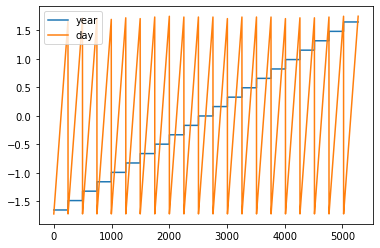

In [10]:
x_plot = pd.DataFrame(StandardScaler().fit_transform(X), columns=['year', 'day']).plot()

Iteramos entrenando un GP con kernel rbf sobre los años anteriores a n y el primer trimeste de n, y predecimos el resto del año n para n entre 2016 y 2021.

Predicting year 2011 with data from 2005 to 2010
Elapsed time: 69.577s
Log-marginal-likelihood: 1085.881
Predicting year 2012 with data from 2006 to 2011
Elapsed time: 70.074s
Log-marginal-likelihood: 979.236
Predicting year 2013 with data from 2007 to 2012
Elapsed time: 63.849s
Log-marginal-likelihood: 893.821
Predicting year 2014 with data from 2008 to 2013
Elapsed time: 71.065s
Log-marginal-likelihood: 987.090
Predicting year 2015 with data from 2009 to 2014
Elapsed time: 71.435s
Log-marginal-likelihood: 838.129
Predicting year 2016 with data from 2010 to 2015
Elapsed time: 74.725s
Log-marginal-likelihood: 748.493
Predicting year 2017 with data from 2011 to 2016
Elapsed time: 72.692s
Log-marginal-likelihood: 445.554
Predicting year 2018 with data from 2012 to 2017
Elapsed time: 71.414s
Log-marginal-likelihood: 308.725
Predicting year 2019 with data from 2013 to 2018
Elapsed time: 61.673s
Log-marginal-likelihood: 190.951
Predicting year 2020 with data from 2014 to 2019
Elapsed time: 

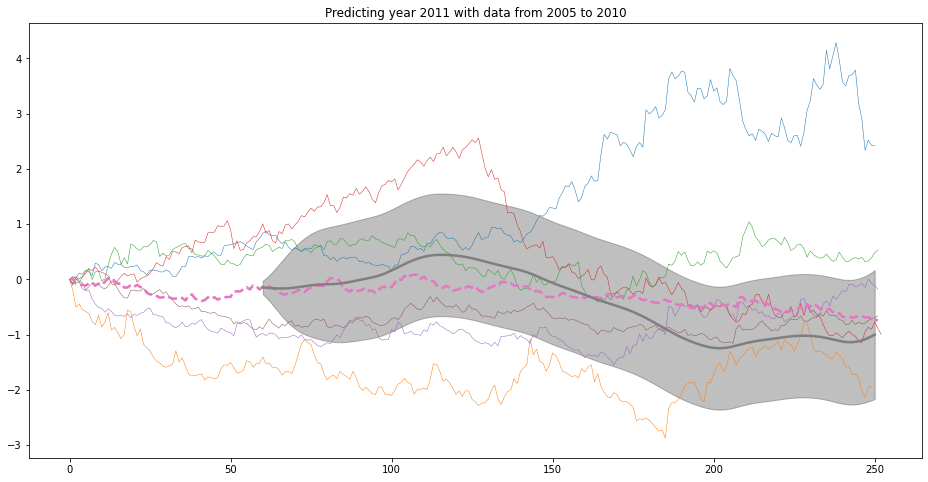

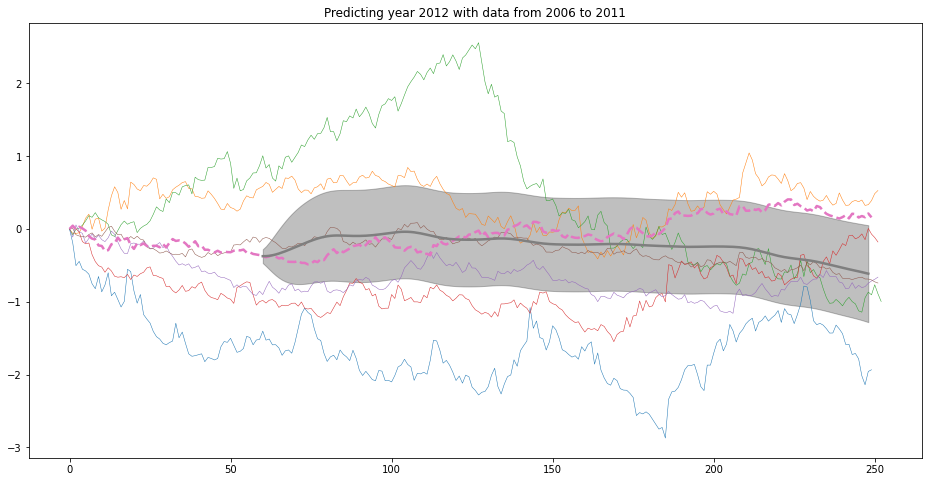

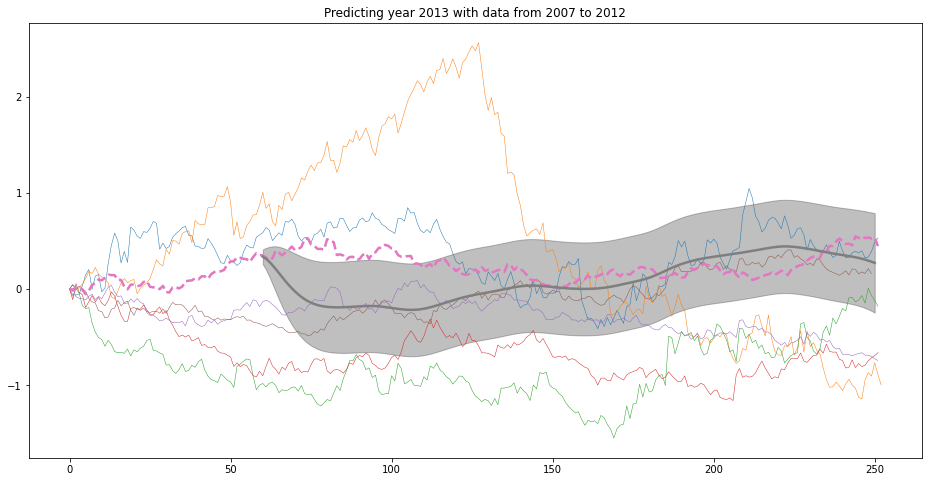

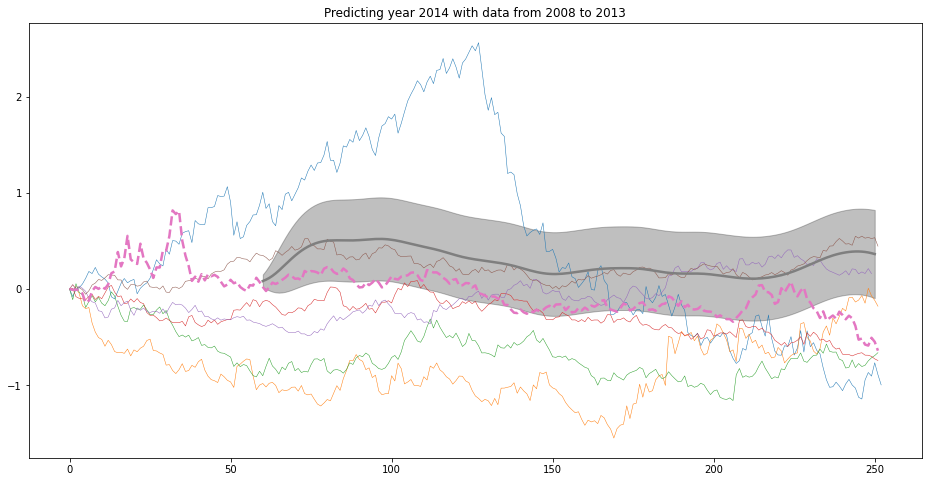

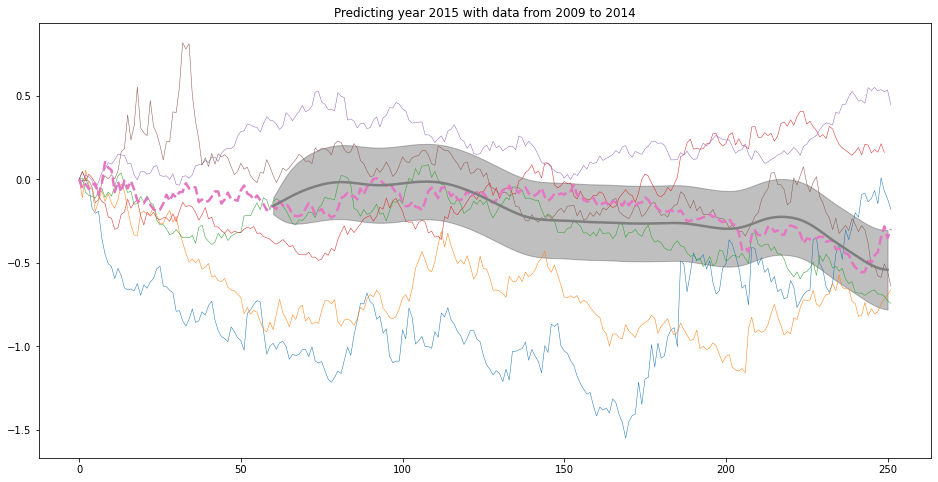

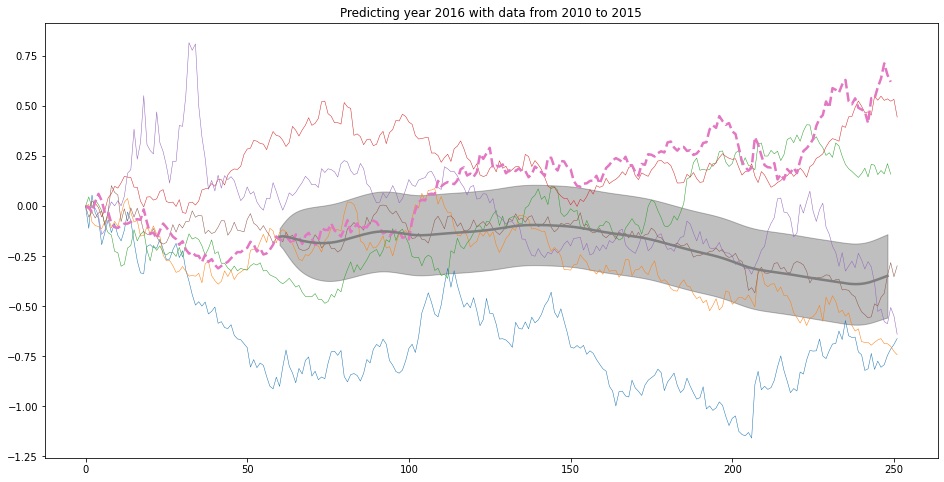

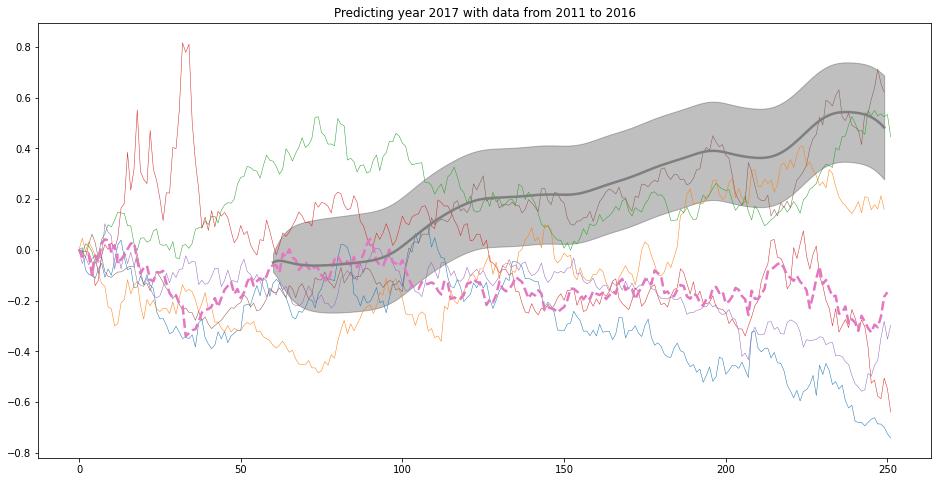

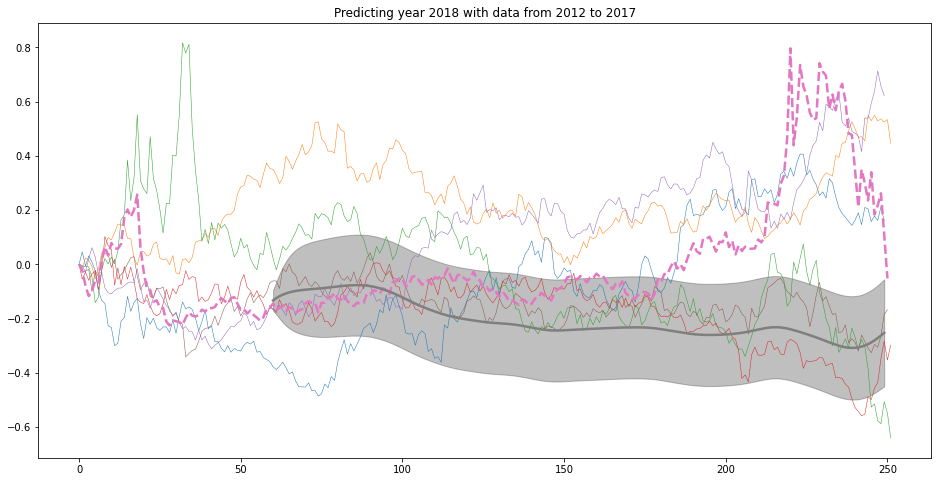

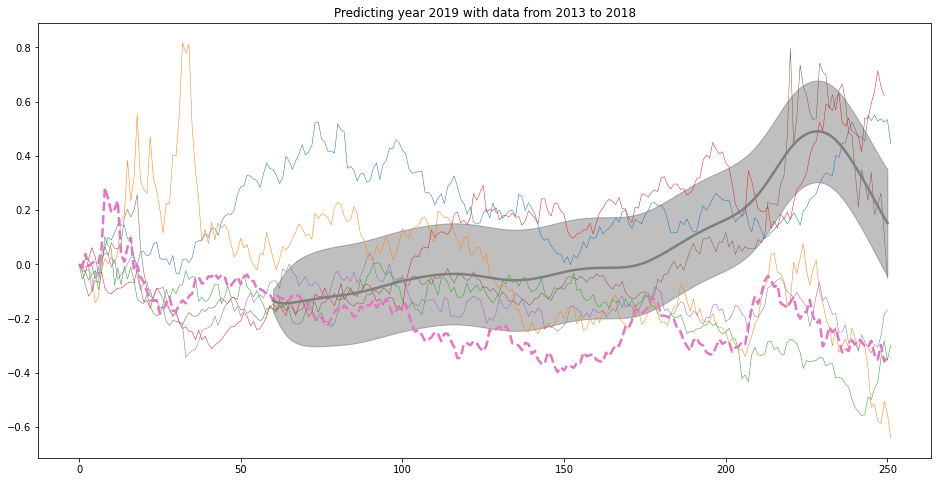

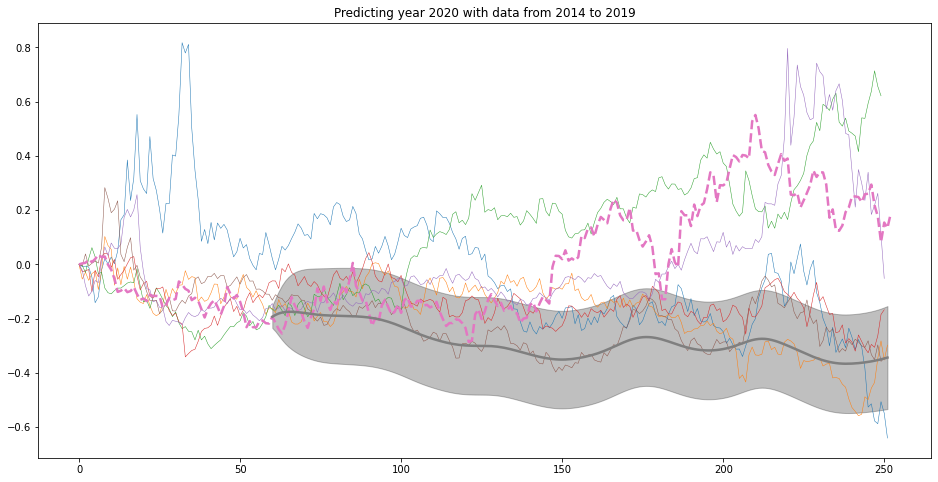

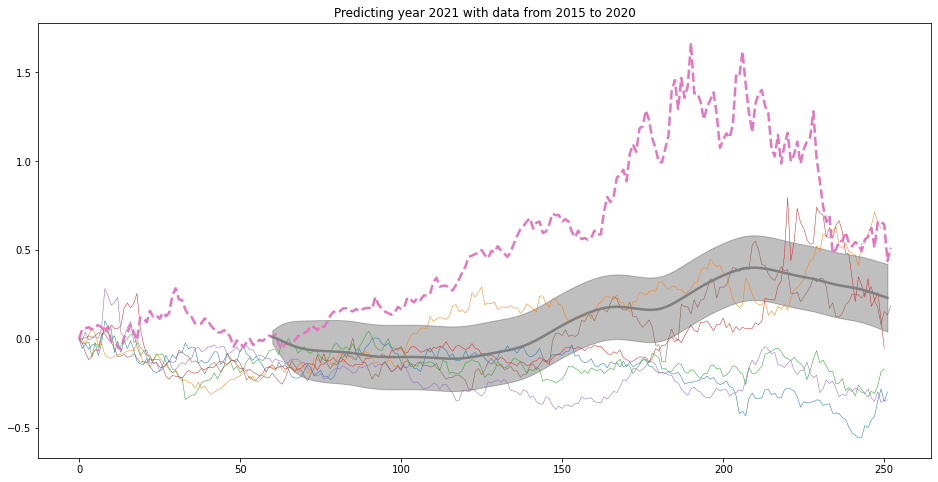

In [11]:
years_pred, days_pred, n_years = range(2011, 2022), 60, 6

sc = StandardScaler()
sc.fit_transform(X)

for year_pred in years_pred:
    
    title = 'Predicting year {} with data from {} to {}'.format(year_pred, year_pred - n_years, year_pred - 1)
    print(title)
    
    mask_train = ((X['year'] >= year_pred - n_years) & (X['year'] < year_pred)) | ((X['year'] == year_pred) & (X['day'] <= days_pred))
    mask_test = (X['year'] == year_pred) & (X['day'] > days_pred)
    
    X_train = X.loc[mask_train]
    X_train = pd.DataFrame(sc.transform(X_train), columns=['year', 'day'])
    y_train = y[mask_train]
    
    X_test = X.loc[mask_test]
    X_test = pd.DataFrame(sc.transform(X_test), columns=['year', 'day'])
    y_test = y[mask_test]
    
    kernel = ConstantKernel() * RationalQuadratic() + ConstantKernel() * WhiteKernel()
    gp = GaussianProcessRegressor(kernel=kernel,
                                  normalize_y=True,
                                  n_restarts_optimizer=3,
                                  alpha=0.01,
                                  random_state=0)
    t0 = time()
    gp.fit(X_train, y_train)
    print("Elapsed time: %0.3fs" % (time() - t0))
    print("Log-marginal-likelihood: %.3f" % gp.log_marginal_likelihood(gp.kernel_.theta))
    
    y_pred, y_std = gp.predict(X_test, return_std=True)
    
    hco = natural_gas_years.loc[:,'{}-01-01'.format(year_pred - n_years - 1):'{}-01-01'.format(year_pred - 1)].plot(figsize=(16,8), legend=False, linewidth=.5, title=title)
    p = hco.plot(natural_gas_years[str(year_pred)], linewidth=2.5, linestyle='--')
    y_plot, y_plot[days_pred:] = [None] * (len(y_pred) + days_pred), y_pred
    p = hco.plot(y_plot, linewidth=2.5)
    p = hco.fill_between(range(days_pred, len(y_pred) + days_pred), y_pred - y_std, y_pred + y_std, alpha=0.25, color='k')
    f = hco.get_figure()
    f.savefig('Figures/{}.png'.format(year_pred))